In [8]:
import wandb
import ast
import argparse
import os
from lineflow.helpers import get_device
from lineflow.learning.helpers import (
    make_stacked_vec_env,
)
from lineflow.learning.curriculum import CurriculumLearningCallback
from lineflow.examples import (
    WaitingTime,
    ComplexLine
)

import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import (
    HeteroConv,
    GCNConv,
    SAGEConv,
    TransformerConv,
    HGTConv,
)
from torch.nn import Linear
from wandb.integration.sb3 import WandbCallback
import networkx as nx

In [9]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Add nodes
    for node_type in data.node_types:
        for i in range(data[node_type].num_nodes):
            G.add_node((node_type, i), node_type=node_type)

    # Add edges with types
    for edge_type in data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index
        for src, dst in zip(edge_index[0], edge_index[1]):
            G.add_edge((src_type, int(src)), (dst_type, int(dst)), key=rel_type, rel_type=rel_type)

    return G


In [10]:
def create_manufacturing_layout(G):
    """Create a hierarchical layout for manufacturing systems"""
    pos = {}
    
    # Define hierarchy levels
    levels = {
        'Source': 0,
        'Magazine': 1, 
        'Assembly': 2,
        'Switch': 3,
        'Sink': 4,
        'WorkerPool': 1.5,  # Between magazine and assembly
        'Worker': 1.5
    }
    
    # Group nodes by type
    node_groups = {}
    for node in G.nodes():
        node_type = node[0]
        if node_type not in node_groups:
            node_groups[node_type] = []
        node_groups[node_type].append(node)
    
    # Position nodes by level and spread horizontally
    for node_type, nodes in node_groups.items():
        level = levels.get(node_type, 2)
        for i, node in enumerate(nodes):
            x = i - len(nodes)/2  # Center horizontally
            y = -level  # Negative to flow top to bottom
            pos[node] = (x, y)
    
    return pos

In [11]:
data = torch.load('../data/complex_line_graph_n_assemblies6_waiting_time2.pt',weights_only=False) # test graph

In [12]:
data_test = data['graph'][0]

In [13]:
data_test

HeteroData(
  Magazine={ x=[1, 5] },
  WorkerPool={ x=[1, 7] },
  Sink={ x=[1, 4] },
  Source={ x=[1, 6] },
  Switch={ x=[1, 6] },
  Assembly={ x=[6, 7] },
  (WorkerPool, assigned_to, Assembly)={
    edge_index=[2, 6],
    edge_attr=[6, 0],
  },
  (Sink, connects_to, Magazine)={
    edge_index=[2, 1],
    edge_attr=[1, 2],
  },
  (Source, connects_to, Switch)={
    edge_index=[2, 1],
    edge_attr=[1, 2],
  },
  (Switch, connects_to, Assembly)={
    edge_index=[2, 6],
    edge_attr=[6, 2],
  },
  (Magazine, connects_to, Assembly)={
    edge_index=[2, 1],
    edge_attr=[1, 2],
  },
  (Assembly, connects_to, Assembly)={
    edge_index=[2, 5],
    edge_attr=[5, 2],
  },
  (Assembly, connects_to, Sink)={
    edge_index=[2, 1],
    edge_attr=[1, 2],
  },
  (Magazine, self_loop, Magazine)={
    edge_index=[2, 1],
    edge_attr=[1, 5],
  },
  (WorkerPool, self_loop, WorkerPool)={
    edge_index=[2, 1],
    edge_attr=[1, 7],
  },
  (Sink, self_loop, Sink)={
    edge_index=[2, 1],
    edge_attr

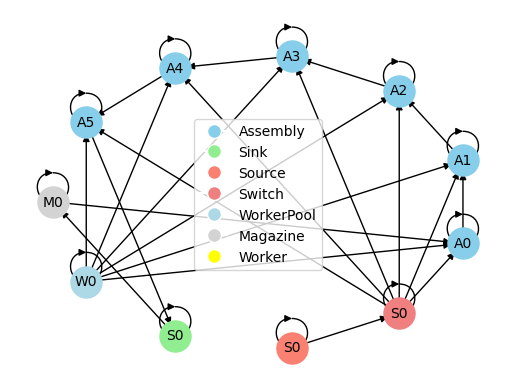

In [14]:
import matplotlib.pyplot as plt
data = data['graph'][0]
G = hetero_to_networkx(data)

# Layout
# pos = nx.spring_layout(G, seed=42)
pos = create_manufacturing_layout(G) 
pos = nx.shell_layout(G)  
# Draw nodes with type labels
node_colors = {
    'Assembly': 'skyblue',
    'Sink': 'lightgreen',
    'Source': 'salmon',
    'Switch': 'lightcoral',
    'WorkerPool': 'lightblue',
    'Magazine': 'lightgrey',
    'Worker': 'yellow',
}
for node_type in data.node_types:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n[0] == node_type],
        node_color=node_colors[node_type],
        label=node_type,
        node_size=500
    )

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={n: f"{n[0][0]}{n[1]}" for n in G.nodes}, font_size=10)

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Assembly', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sink', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Source', markerfacecolor='salmon', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Switch', markerfacecolor='lightcoral', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='WorkerPool', markerfacecolor='lightblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Magazine', markerfacecolor='lightgrey', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Worker', markerfacecolor='yellow', markersize=10)
])
plt.axis('off')
plt.show()


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv
from torch_geometric.data import HeteroData
from torch.nn import Linear
from torch_geometric.nn import HeteroConv, SAGEConv,TransformerConv, HGTConv



class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in state.node_types:
            in_channels = state.x_dict[node_type].shape[1]
            self.lin_dict[node_type] = Linear(in_channels, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, state.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict


model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=1)

# model = HGT(state.metadata())  # metadata = (node_types, edge_types)
out = model(state.x_dict, state.edge_index_dict)

In [7]:
state.x_dict

{'Source': tensor([[0., 1., 0., 1., 1., 0.],
         [0., 0., 0., 1., 1., 0.]]),
 'Assembly': tensor([[ 0.,  1.,  0.,  0.,  0.,  1., 20.]]),
 'Sink': tensor([[0., 1., 0., 0.]])}

In [11]:
out['Source'][1].shape

torch.Size([64])

In [26]:
env_train.action_space.nvec

array([100])

In [23]:
# from ppo import Agent
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
from torch.distributions.categorical import Categorical

In [ ]:

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs, input_feat_dim):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_feat_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        
        self.actor = nn.Sequential(
            layer_init(nn.Linear(input_feat_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.action_space.nvec[0]), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)

In [43]:

# Define undefined variables (without using args)
env_id = "WaitingTime-v0"
exp_name = "ppo_experiment"
seed = 42
torch_deterministic = True
cuda = True
track = False
wandb_project_name = "ppo_project"
wandb_entity = None

num_envs = 1
num_steps = 128
num_minibatches = 4
total_timesteps = 100_000
learning_rate = 2.5e-4
anneal_lr = True
gamma = 0.99
gae_lambda = 0.95
update_epochs = 4
clip_coef = 0.2
ent_coef = 0.01
vf_coef = 0.5
max_grad_norm = 0.5
clip_vloss = True
norm_adv = True
target_kl = None


batch_size = int(num_envs * num_steps)
minibatch_size = int(batch_size // num_minibatches)
num_iterations = total_timesteps // batch_size
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"
if track:
    import wandb
    import types

    wandb.init(
            project=wandb_project_name,
            entity=wandb_entity,
            sync_tensorboard=True,
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
writer = SummaryWriter(f"runs/{run_name}")


# TRY NOT TO MODIFY: seeding
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")

# env setup
# envs = gym.vector.SyncVectorEnv(
#     [make_env(env_id, i, capture_video, run_name) for i in range(num_envs)],
# )
line = WaitingTime(use_graph_as_states=True)
envs = make_stacked_vec_env(
    line=line,
    simulation_end=100+1,
    reward="parts",
    n_envs=1,
    n_stack=1,
)
# assert isinstance(envs.action_space, gym.spaces.MultiDiscrete), "only discrete action space is supported"
graph_encoder_feature_dim = 64
graph_encoder = HGT(hidden_channels=graph_encoder_feature_dim, out_channels=4, num_heads=2, num_layers=1)
agent = Agent(envs, graph_encoder_feature_dim).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
# Calculate the total encoded feature dimension
# This should match the concatenated output from your graph encoder
total_encoded_dim = 64 #* len(state.node_types)  # assuming each node type gets encoded to 64 dims

# ALGO Logic: Storage setup
obs = torch.zeros((num_steps, num_envs, total_encoded_dim)).to(device)
actions = torch.zeros((num_steps, num_envs), dtype=torch.long).to(device)  # Single action, not vector
logprobs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=seed)

# Move graph_encoder to device
graph_encoder = graph_encoder.to(device)

# Initial encoding of the hetero graph observation
# Move HeteroData to device
next_obs = next_obs.to(device)
next_obs_graph = graph_encoder(next_obs.x_dict, next_obs.edge_index_dict)
# Concatenate all node type embeddings into a single feature vector
next_obs_encoded = next_obs_graph['Source'][1].unsqueeze(0)

next_obs = next_obs_encoded  # This should be the encoded features, not raw HeteroData
next_done = torch.zeros(num_envs).to(device)

In [44]:
obs.shape

torch.Size([128, 1, 64])

In [45]:
for iteration in range(1, num_iterations + 1):
    # Annealing the rate if instructed to do so.
    if anneal_lr:
        frac = 1.0 - (iteration - 1.0) / num_iterations
        lrnow = frac * learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, num_steps):
        global_step += num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs_raw, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        
        # Process the new HeteroData observation through graph encoder
        # Move HeteroData to device
        next_obs_raw = next_obs_raw.to(device)
        next_obs_graph = graph_encoder(next_obs_raw.x_dict, next_obs_raw.edge_index_dict)
        # Concatenate all node type embeddings into a single feature vector
        next_obs = next_obs_graph['Source'][1].unsqueeze(0)
    
        next_done = torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1, total_encoded_dim))  # Use the correct encoded dimension
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)  # Single action dimension
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

        if target_kl is not None and approx_kl > target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()

AttributeError: 'HeteroData' has no attribute 'get_observations'